In [1]:
import sys
sys.path.append(r'D:\API\cocoapi\PythonAPI')
from pycocotools.dataset import Loader

from matplotlib import pyplot as plt
%matplotlib inline

import mxnet  as mx
from mxnet import gluon, nd
from mxnet.gluon import nn
from gluoncv.model_zoo import vgg16

from gluoncv.nn.bbox import BBoxCornerToCenter, BBoxClipToImage
from gluoncv.nn.coder import NormalizedBoxCenterDecoder
from gluoncv.model_zoo.rpn.anchor import RPNAnchorGenerator
from gluoncv.model_zoo.rpn.proposal import RPNProposal

In [2]:
dataType = 'val2014'
root = 'E:/Data/coco'
catNms = ['cat', 'dog']
annType = 'annotations_trainval2014'

loader = Loader(dataType, catNms, root, annType)

Loading json in memory ...
used time: 7.68731 s
Loading json in memory ...
creating index...
index created!
used time: 81.2214 s


((800, 800, 3), (1, 3, 800, 800))

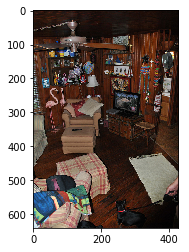

In [3]:
import cv2

img, labels = loader[30]
plt.imshow(img);
img = cv2.resize(img, (800, 800))
img_ = img.transpose((2, 1, 0))

imgs = nd.array(img_).expand_dims(0)
img.shape, imgs.shape

In [4]:
net = vgg16(pretrained=True)
features = net.features[:-5]

In [5]:
x = imgs
for layer in features:
    x = layer(x)
    print(x.shape)

(1, 64, 800, 800)
(1, 64, 800, 800)
(1, 64, 800, 800)
(1, 64, 800, 800)
(1, 64, 400, 400)
(1, 128, 400, 400)
(1, 128, 400, 400)
(1, 128, 400, 400)
(1, 128, 400, 400)
(1, 128, 200, 200)
(1, 256, 200, 200)
(1, 256, 200, 200)
(1, 256, 200, 200)
(1, 256, 200, 200)
(1, 256, 200, 200)
(1, 256, 200, 200)
(1, 256, 100, 100)
(1, 512, 100, 100)
(1, 512, 100, 100)
(1, 512, 100, 100)
(1, 512, 100, 100)
(1, 512, 100, 100)
(1, 512, 100, 100)
(1, 512, 50, 50)
(1, 512, 50, 50)
(1, 512, 50, 50)
(1, 512, 50, 50)
(1, 512, 50, 50)
(1, 512, 50, 50)
(1, 512, 50, 50)


In [11]:
from gluoncv.model_zoo.rpn import RPN

In [16]:
stride = 8  # 特征图的每个像素感受野大小，通常为原图和特征图尺寸比例
base_size = 16
scales = [8, 16, 32]  # 尺度，面积比
ratios = [0.5, 1, 2]  # window（滑动窗口） 与锚框的面积的比率（aspect ratios）
alloc_size = (50, 50)  # 默认的特征图大小(H,W)，以后每次生成直接索引切片

channels = 256
clip = None
nms_thresh = .7
train_pre_nms = 2
train_post_nms = 2
test_pre_nms = 2
test_post_nms = 2
min_size = 10
self = RPN(channels, stride, base_size, scales, ratios, alloc_size,
           clip, nms_thresh, train_pre_nms, train_post_nms,
           test_pre_nms, test_post_nms, min_size)
self.initialize()
x = features(imgs)
x.shape

(1, 512, 50, 50)

In [17]:
anchors = self.anchor_generator(x)
anchors


[[[ -84.  -40.   99.   55.]
  [-176.  -88.  191.  103.]
  [-360. -184.  375.  199.]
  ...
  [ 356.  312.  443.  487.]
  [ 312.  224.  487.  575.]
  [ 224.   48.  575.  751.]]]
<NDArray 1x22500x4 @cpu(0)>

In [18]:
F = nd
x = self.conv1(x)
raw_rpn_scores = self.score(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1,1))
rpn_scores = F.sigmoid(F.stop_gradient(raw_rpn_scores))
rpn_box_pred = self.loc(x).transpose(axes=(0, 2, 3, 1)).reshape((0, -1, 4))

In [19]:
anchor, score, bbox_pred, img = anchors, rpn_scores, F.stop_gradient(rpn_box_pred), imgs

In [22]:
G = nd.array(labels)
G


[[239.53 555.84  93.42  84.16  18.  ]
 [234.98 233.    80.56  81.94  72.  ]
 [  0.   254.28 207.24 215.05  63.  ]
 [  0.   470.52 173.05 157.94  63.  ]
 [385.42 482.7   42.54  62.78   1.  ]
 [290.9  271.62  89.87 138.83  62.  ]
 [241.04 560.21  91.43  71.48  17.  ]
 [  0.   471.6  174.36 168.4   62.  ]
 [ 83.79 254.75 123.66 116.44  62.  ]]
<NDArray 9x5 @cpu(0)>

In [23]:
from gluoncv.model_zoo.rpn.proposal import RPNProposal
from mxnet import autograd

In [24]:
clip = None
nms_thresh = .7
train_pre_nms = 5
train_post_nms = 5
test_pre_nms = 5
test_post_nms = 5
min_size = 800
stds = (.1, .1, .2, .2)
P = RPNProposal(clip, nms_thresh, train_pre_nms, train_post_nms, test_pre_nms, test_post_nms, min_size, stds)
P.initialize()

In [25]:
if autograd.is_training():
    pre_nms = P._train_pre_nms
    post_nms = P._train_post_nms
else:
    pre_nms = P._test_pre_nms
    post_nms = P._test_post_nms

In [ ]:
with autograd.pause():
    # restore bounding boxes
    roi = P._box_decoder(bbox_pred, P._box_to_center(anchor))
    # clip rois to image's boundary
    # roi = F.Custom(roi, img, op_type='bbox_clip_to_image')
    roi = P._clipper(roi, imgs)
    xmin, ymin, xmax, ymax = roi.split(axis=-1, num_outputs=4)
    width = xmax - xmin
    height = ymax - ymin
    invalid = (width < P._min_size) + (height < P._min_size)
    score = F.where(invalid, F.ones_like(invalid) * -1, score)
    invalid = F.repeat(invalid, axis=-1, repeats=4)
    roi = F.where(invalid, F.ones_like(invalid) * -1, roi)

    # Non-maximum suppression
    pre = F.concat(score, roi, dim=-1)
    tmp = F.contrib.box_nms(pre, overlap_thresh=P._nms_thresh, topk=pre_nms,
                            coord_start=1, score_index=0, id_index=-1, force_suppress=True)

    # slice post_nms number of boxes
    result = F.slice_axis(tmp, axis=1, begin=0, end=post_nms)
    rpn_scores = F.slice_axis(result, axis=-1, begin=0, end=1)
    rpn_bbox = F.slice_axis(result, axis=-1, begin=1, end=None)